# **This implementation compares the performances of self implemented ADAM and NADAM optimizers on the MNIST Dataset in pytorch.**

In [0]:
# To get Tensorflow 2.0 in Google Colab.
try:
  %tensorflow_version 2.x
except Exception:
  pass

**Loading & normalizing the MNIST Dataset.**

In [0]:
import tensorflow as tf
import numpy
from sklearn.utils import shuffle

# Getting the dataset and normalizing.
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0; x_test = x_test/255.0

**Post normalization of the input data, the architection of the model is defined as mentioned in the paper consisting of 2 hidden layers of 1000 units each, alongside drops, for which I have considered the probability for dropping out of node p = 0.5.**

In [0]:
# Calling necessary modules essential for the implementation of the model.
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model

# The return function, when called, will return object of the model.
def return_Model():
  
  # Extending the model class.
  class Model_MNIST(Model):
    def __init__(self):
      super(Model_MNIST, self).__init__()
      # Define layers.
      self.flatten = Flatten()
      self.hidden1 = Dense(1000, activation='relu')
      self.hidden2 = Dense(1000, activation='relu')
      self.dropout = Dropout(0.5)
      self.final = Dense(10, activation='softmax')

    # Assigning the forward pass.
    def call(self, x):
      x = self.dropout(x)
      x = self.flatten(x)
      x = self.hidden1(x)
      x = self.dropout(x)
      x = self.hidden2(x)
      x = self.dropout(x)
      x = self.final(x)
      return x
  
  # Creating the object of the model and returning the same.
  model_mnist = Model_MNIST()
  return(model_mnist)

**Later, we implement our own version of Adam optimizer, and also another optimizer which combines both Adam and Nesterov's momentum. Here, it is refer to as Nadam.**

In [0]:
# Calling necessary modules for implemnetation of the a proper custom optimizer.
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.framework import ops
from tensorflow.python.training import optimizer

**Implementation of Adam optimizer.**

In [0]:
class MyAdam(optimizer.Optimizer):

    def __init__(self, learning_rate=0.01, gamma=0.9, beta = 0.999, epsilon=1e-8, use_locking=False, name="MyAdam"):
      
      super(MyAdam, self).__init__(use_locking, name)
      
      self._lr = learning_rate; self._gamma = gamma; self._beta = beta; self._epsilon = epsilon
      self._lr_t = None; self._gamma_t = None; self._beta_t = None; self._epsilon_t = None
      
    def _prepare(self):
      self._lr_t = ops.convert_to_tensor(self._lr)
      self._gamma_t = ops.convert_to_tensor(self._gamma)
      self._beta_t = ops.convert_to_tensor(self._beta)
      self._epsilon_t = ops.convert_to_tensor(self._epsilon)

    def _create_slots(self, var_list):
      for v in var_list:
        self._zeros_slot(v, "mt", self._name)
        self._zeros_slot(v, "vt", self._name)
        self._zeros_slot(v, "t", self._name)

    def _resource_apply_dense(self, grad, var):

      lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
      gamma_t = math_ops.cast(self._gamma_t, var.dtype.base_dtype)
      beta_t = math_ops.cast(self._beta_t, var.dtype.base_dtype)
      epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)

      # Getting the updated t value required for correction.
      t = self.get_slot(var, "t")
      t_new = t + 1
      
      # Getting the moment value and calculating the corrected updated value.
      mt = self.get_slot(var, "mt")
      mt_new = mt.assign((gamma_t * mt) + ((1 - gamma_t) * grad))
      corr_mt_new = mt_new / (1-tf.pow(gamma_t,t_new))

      # Getting the velocity value and calculating the corrected updated value.
      vt = self.get_slot(var, "vt")
      vt_new = vt.assign((beta_t * vt) + ((1 - beta_t) * tf.square(grad)))
      corr_vt_new = vt_new / (1-tf.pow(beta_t,t_new))

      # Updating weights based on the final update equation.
      update_val = (lr_t * corr_mt_new) / tf.sqrt(corr_vt_new + epsilon_t)

      var_update = state_ops.assign_sub(var, update_val)
      return control_flow_ops.group(*[var_update,mt_new,vt_new,t_new])

**Implementation of the Nadam Optimizer.**

In [0]:
class MyNadam(optimizer.Optimizer):

    def __init__(self, learning_rate=0.01, gamma=0.9, beta = 0.999, epsilon=1e-8, use_locking=False, name="MyAdam"):
      
      super(MyNadam, self).__init__(use_locking, name)
      
      self._lr = learning_rate; self._gamma = gamma; self._beta = beta; self._epsilon = epsilon
      self._lr_t = None; self._gamma_t = None; self._beta_t = None; self._epsilon_t = None
      
    def _prepare(self):
      self._lr_t = ops.convert_to_tensor(self._lr)
      self._gamma_t = ops.convert_to_tensor(self._gamma)
      self._beta_t = ops.convert_to_tensor(self._beta)
      self._epsilon_t = ops.convert_to_tensor(self._epsilon)

    def _create_slots(self, var_list):
      for v in var_list:
        self._zeros_slot(v, "mt", self._name)
        self._zeros_slot(v, "vt", self._name)
        self._zeros_slot(v, "t", self._name)

    def _resource_apply_dense(self, grad, var):

      lr_t = math_ops.cast(self._lr_t, var.dtype.base_dtype)
      gamma_t = math_ops.cast(self._gamma_t, var.dtype.base_dtype)
      beta_t = math_ops.cast(self._beta_t, var.dtype.base_dtype)
      epsilon_t = math_ops.cast(self._epsilon_t, var.dtype.base_dtype)

      # Getting the updated t value required for correction.
      t = self.get_slot(var, "t")
      t_new = t + 1
      
      # Getting the moment value and calculating the corrected updated value.
      mt = self.get_slot(var, "mt")
      mt_new = mt.assign((gamma_t * mt) + ((1 - gamma_t) * grad))
      corr_mt_new = mt_new / (1-tf.pow(gamma_t,t_new))
      corr_gamma_grad = ((1 - gamma_t) * grad) / (1-tf.pow(gamma_t,t_new))
      # Getting the lookahed momentum
      mt_lookahead = (gamma_t * corr_mt_new) + corr_gamma_grad

      # Getting the velocity value and calculating the corrected updated value.
      vt = self.get_slot(var, "vt")
      vt_new = vt.assign((beta_t * vt) + ((1 - beta_t) * tf.square(grad)))
      corr_vt_new = vt_new / (1-tf.pow(beta_t,t_new))

      # Updating weights based on the final update equation, based on the look ahead momentum.
      update_val = (lr_t * mt_lookahead) / tf.sqrt(corr_vt_new + epsilon_t)

      var_update = state_ops.assign_sub(var, update_val)
      return control_flow_ops.group(*[var_update,mt_new,vt_new,t_new])

**After defining the optimizers I have defined the function calculate_grad(), upon which the final call-graphs will be created. The creation of the call-graph makes the execution much much faster. The purpose of the function is to calculate the gradient, and inside the function the optimizer is called to backpropagate the error and update the weights. This function is wrapped with 'tf.function()', so that, on different instance of the call graph.**

In [0]:
def calculate_grad(model,loss_criterion, x, y, optimizerObj, global_step):
  # tf.GradientTape() calculates the gradient of the los with respect to the weights.
  with tf.GradientTape() as tape:
    # For the prediction, loss is being calculated.
    predictions = model(x)
    loss_value = loss_criterion(y,predictions)
  # Gradient for the loss is also calculated.
  gradients = tape.gradient(loss_value, model.trainable_variables)
  # The optimizer is called to optimize the weights with respect to the gradients.
  optimizerObj.apply_gradients(zip(gradients, model.trainable_variables),global_step)
  return loss_value

**Finally, we define the train_model(), this function is called each time when an optimizer's performance needs to be checked. This functions trains the model based on the chosen optimizer, returns the losses and accuracies per epoch for the training.**

In [0]:
def train_model(model,optimizerObj,train_dataset,loss_criterion,global_step,n_epochs,batch_size):

  loss_per_epoch = []
  accuracy_per_epoch = []

  # Wrapping the calculate_grad() to generate the call-graph.
  graph_calculate_grad = tf.function(calculate_grad)

  # Computation for each epoch.
  for epoch in range(n_epochs):
    
    # These two are helper functions to calcuate the running mean of loss, and accuracy.
    epoch_loss = tf.keras.metrics.Mean(name='epoch_loss')
    epoch_accuracy =  tf.keras.metrics.SparseCategoricalAccuracy(name='epoch_accuracy')

    # Computation for each mini-batch.
    for x, y in train_dataset:

      x = tf.dtypes.cast(x, tf.float32); y = tf.dtypes.cast(y, tf.float32)
      
      # The call-graph for is called. The loss is calculated, the gradients of losses with respect to the weights are generated, and the optimizer optimizes the weights.
      loss_amount = graph_calculate_grad(model,loss_criterion,x,y,optimizerObj,global_step)
      # Prediction for accuracy.
      predictions = model(x)

      # Calculate the loss and accuracy per epoch.
      epoch_loss(loss_amount)
      epoch_accuracy(y,predictions)

    loss_per_epoch.append(epoch_loss.result())
    accuracy_per_epoch.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.5f}, Accuracy: {:.3%}".format(epoch+1, epoch_loss.result(), epoch_accuracy.result()))

  # The losses and accuracies are returned.
  return(loss_per_epoch,accuracy_per_epoch)

**Now for 200 epochs each of the optimizers optimizes the weights.**

In [0]:
# Number of epochs & batch size have been taken as 200 and 128 respectively, as given in the paper.
n_epochs = 200; batch_size = 128
# Since learning rate was not mention, it was observed, that 5e-4 is a good choice, and was taken.
lr = 5e-4

# The train dataset iterator was created.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(batch_size)
# The loss was defined.
loss_criterion = tf.keras.losses.SparseCategoricalCrossentropy()

# The optimizers were declared.
optimizerObj_Adam = MyAdam(learning_rate=lr, gamma=0.9, beta = 0.999)
optimizerObj_Nadam = MyNadam(learning_rate=lr, gamma=0.9, beta = 0.999)

# Performance of each optimizer was observed

#Adam
print('Adam')
model = return_Model()
global_step = tf.Variable(0)
loss_per_epoch, accuracy_per_epoch = train_model(model,optimizerObj_Adam,train_dataset,loss_criterion,global_step,n_epochs,batch_size)
loss_adam = numpy.array(loss_per_epoch); accuracy_adam = numpy.array(accuracy_per_epoch)

#Nesterov's Adam (Nadam)
print('Nadam')
model = return_Model()
global_step = tf.Variable(0)
loss_per_epoch, accuracy_per_epoch = train_model(model,optimizerObj_Nadam,train_dataset,loss_criterion,global_step,n_epochs,batch_size)
loss_nadam = numpy.array(loss_per_epoch); accuracy_nadam = numpy.array(accuracy_per_epoch)

Adam
Epoch 001: Loss: 0.20730, Accuracy: 94.765%
Epoch 002: Loss: 0.07948, Accuracy: 97.933%
Epoch 003: Loss: 0.05226, Accuracy: 98.725%
Epoch 004: Loss: 0.03492, Accuracy: 99.195%
Epoch 005: Loss: 0.02520, Accuracy: 99.510%
Epoch 006: Loss: 0.01773, Accuracy: 99.738%
Epoch 007: Loss: 0.01214, Accuracy: 99.877%
Epoch 008: Loss: 0.00824, Accuracy: 99.937%
Epoch 009: Loss: 0.00614, Accuracy: 99.968%
Epoch 010: Loss: 0.00425, Accuracy: 99.977%
Epoch 011: Loss: 0.00317, Accuracy: 99.988%
Epoch 012: Loss: 0.00192, Accuracy: 100.000%
Epoch 013: Loss: 0.00732, Accuracy: 99.975%
Epoch 014: Loss: 0.00420, Accuracy: 99.983%
Epoch 015: Loss: 0.00107, Accuracy: 99.998%
Epoch 016: Loss: 0.00169, Accuracy: 99.993%
Epoch 017: Loss: 0.00093, Accuracy: 100.000%
Epoch 018: Loss: 0.00036, Accuracy: 100.000%
Epoch 019: Loss: 0.00022, Accuracy: 100.000%
Epoch 020: Loss: 0.00016, Accuracy: 100.000%
Epoch 021: Loss: 0.00012, Accuracy: 100.000%
Epoch 022: Loss: 0.00748, Accuracy: 99.967%
Epoch 023: Loss: 0.00

**Plot for loss for different optimizers.**

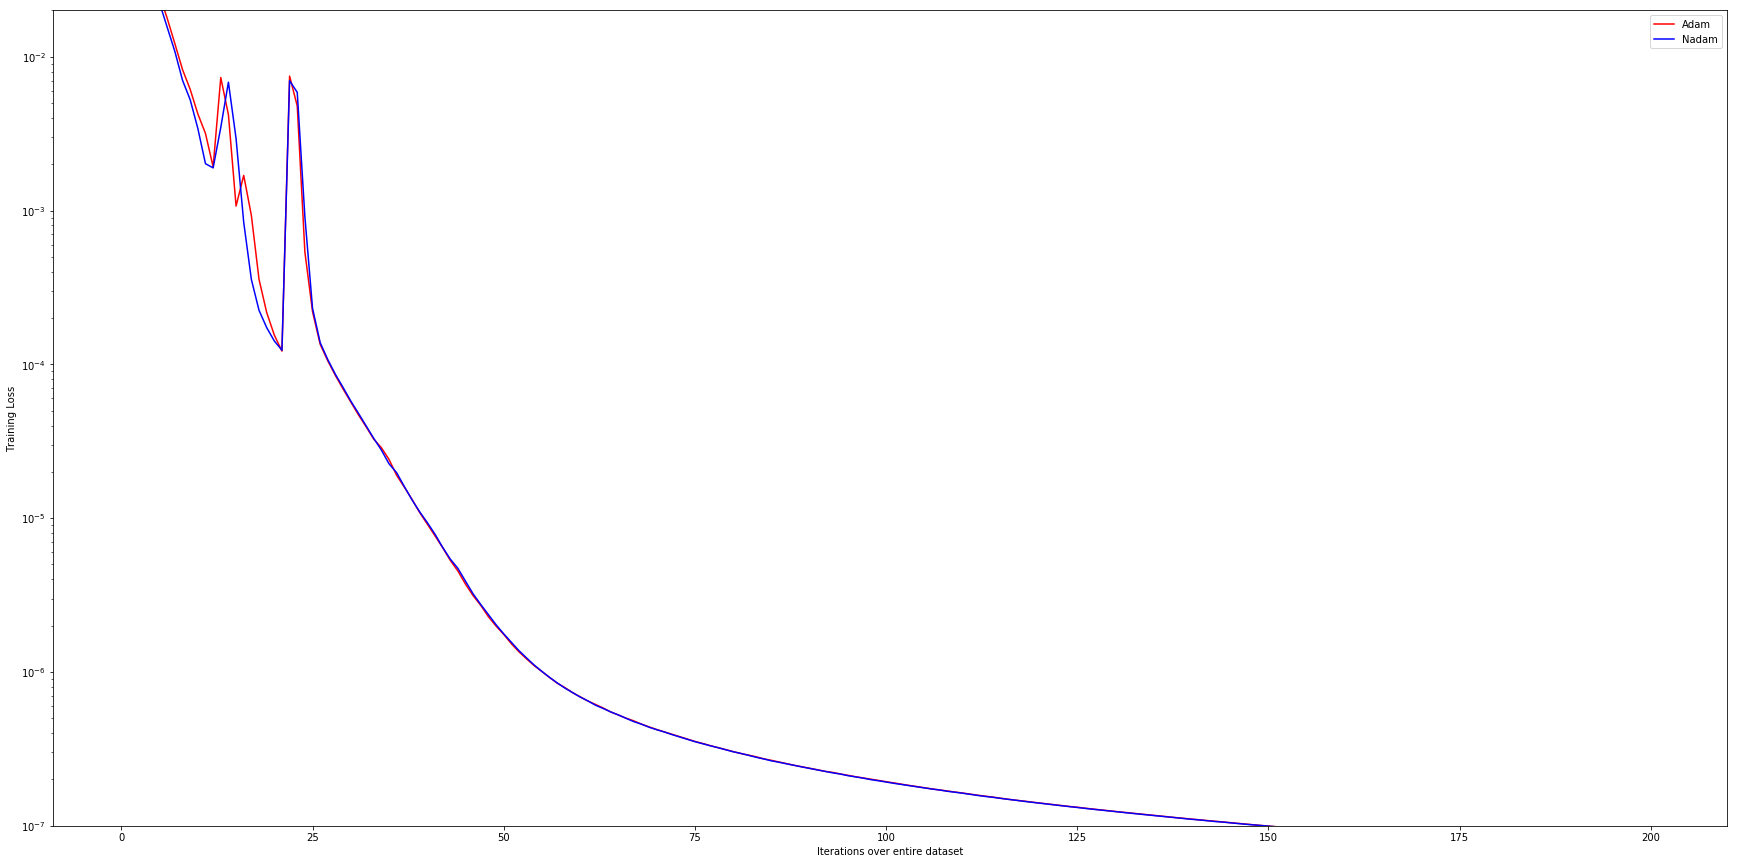

In [0]:
import matplotlib.pyplot as plt

x_axis = numpy.array(list(range(1,n_epochs+1)))
#x_axis = numpy.array(list(range(1,loss_adam.shape[0]+1))
fig = plt.figure(figsize=(30,15))
plt.axes(yscale='log')
plt.plot(x_axis, loss_adam, color='red', label='Adam')
plt.plot(x_axis, loss_nadam, color='blue', label='Nadam')
plt.legend(loc=1)
plt.ylim(0.0000001,0.02)
plt.xlabel('Iterations over entire dataset')
plt.ylabel('Training Loss')
plt.show()

**Plot for accuracies.**

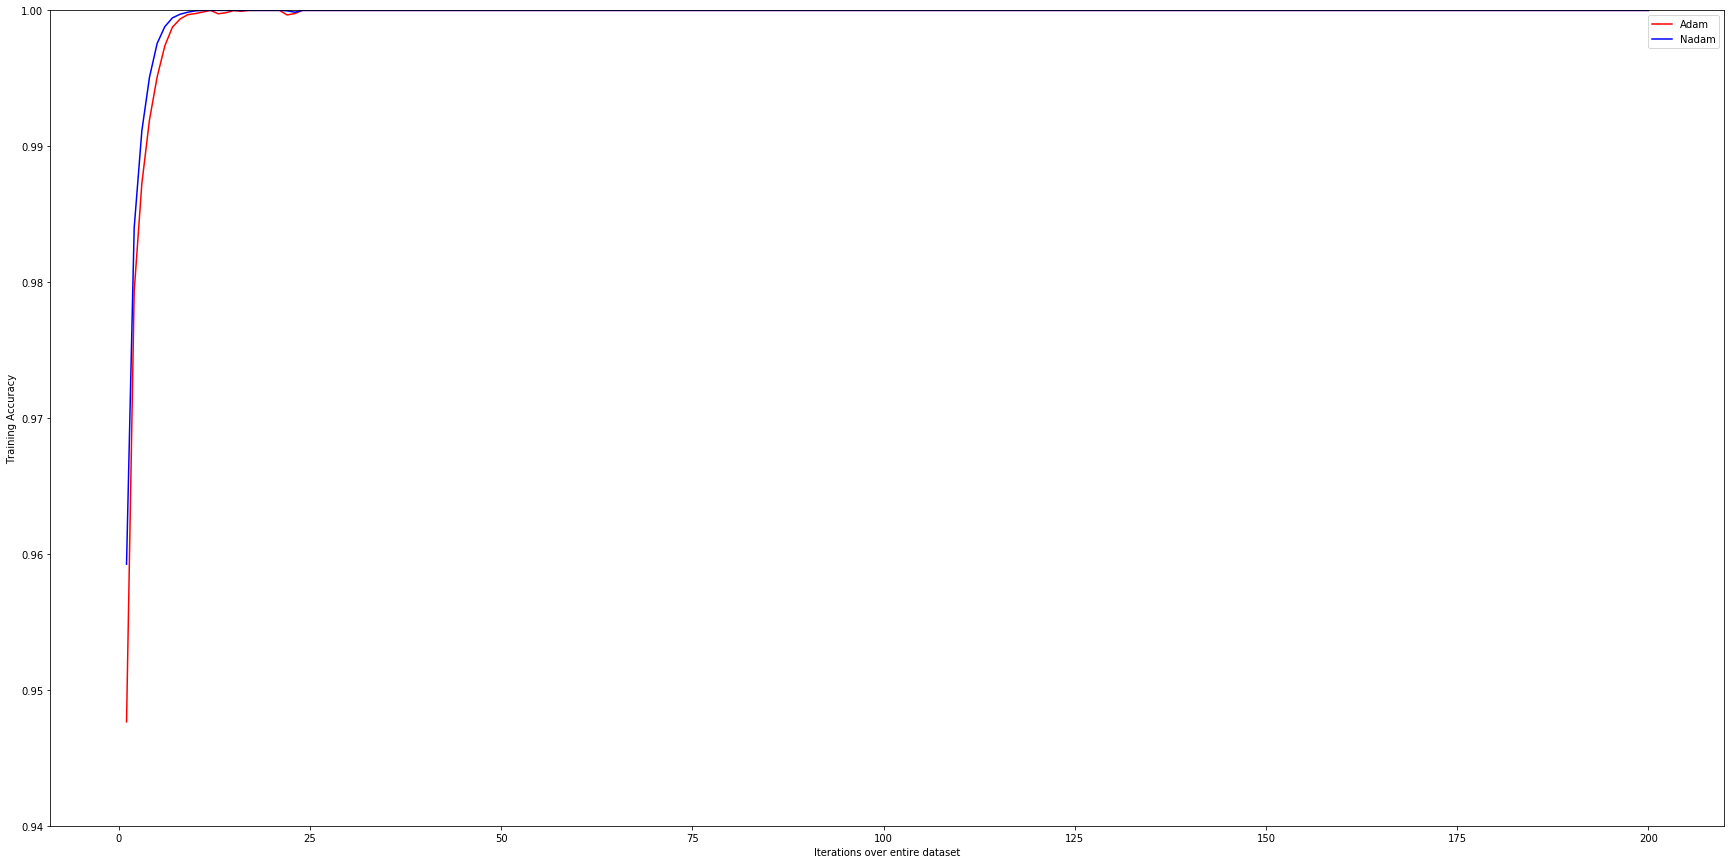

In [0]:
x_axis = numpy.array(list(range(1,n_epochs+1)))
fig = plt.figure(figsize=(30,15))
plt.plot(x_axis, accuracy_adam, color='red', label='Adam')
plt.plot(x_axis, accuracy_nadam, color='blue', label='Nadam')
plt.legend(loc=1)
plt.ylim(0.94,1)
plt.xlabel('Iterations over entire dataset')
plt.ylabel('Training Accuracy')
plt.show()

# **The plot shows that using Nesterov's Momentum instead of the classifical momentum makes the optimization little faster. Thus Nadam seems to be advantageuous than Adam for this dataset.**